In [1]:
## IMPORTS
import pandas as pd
import numpy as np
import h5py
import glob
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

######### gabe hacky styling to emulate some of PBoC Phillips lab style conventions, however hacky. tries to make easier for nigel++
## Styling
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import matplotlib.colors as mcolors
import matplotlib.cm as cm
# sns.set_style('ticks')

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the property to save figures with text as text, not paths
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# default good PBoC colors
baseBlendColor=(224/255, 219/255, 209/255,1) # default background for plots
contrastColor=(209/255, 193/255, 171/255,1) # slightly darker tan for contrasts, e.g. in inset boxes
yellowTanHighlightBoxColor='#FEF0C6'
goodGreyGreenArrowColor='#CCD4C9'

### Griffin style invocation

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.offsetbox import AnchoredText

def plotting_style(grid=False):
    """
    Sets the style to the publication style. To instantiate, simply call
    plotting_style() at the beginning of your script or notebook to force
    all matplotlib plots to adopt the scheme.

    Parameters
    ----------
    grid: bool
      If True, plots will have a thin, white grid in the background. Default
      is False.

    Returns
    -------
    colors: dict
      Returns a dictionary of the standard PBoC 2e color palette.
    """
    rc = {'axes.facecolor': '#E3DCD0',
#               'axes.spines.top': False,
#               'axes.spines.right': False,
#               'axes.spines.left': False,  # Ensure left spine is present
#               'axes.spines.bottom': False,  # Ensure bottom spine is present
#               'axes.spines.left': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
#               'axes.spines.bottom': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
          #'font.family': '/usr/share/fonts/truetype/LucidaSansOT.otf', #'LucidaSansOT.otf',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.alpha': 0.75,
          'grid.color': '#ffffff',
          'axes.grid': grid,
          'ytick.direction': 'in',
          'xtick.direction': 'in',
          'xtick.gridOn': grid,
          'ytick.gridOn': grid,
#               'ytick.major.width':8,
#               'xtick.major.width':8,
#               'ytick.major.size': 8,
#               'xtick.major.size': 8,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'
         }
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('darkgrid', rc=rc)
    return color_palette()

def color_palette():
    """
    Returns a dictionary of the PBOC color palette
    """
    return {'green': '#7AA974', 'light_green': '#BFD598',
              'pale_green': '#DCECCB', 'yellow': '#EAC264',
              'light_yellow': '#F3DAA9', 'pale_yellow': '#FFEDCE',
              'blue': '#738FC1', 'light_blue': '#A9BFE3',
              'pale_blue': '#C9D7EE', 'red': '#D56C55', 'light_red': '#E8B19D',
              'pale_red': '#F1D4C9', 'purple': '#AB85AC',
              'light_purple': '#D4C2D9', 'dark_green':'#7E9D90', 'dark_brown':'#905426'}

def titlebox(
    ax, text, color, bgcolor=None, size=8, boxsize=0.1, pad=0.05, **kwargs
):
    """
    Sets a colored title box above the plot, spanning the entire plot width.

    Parameters
    ----------
    ax : matplotlib axis object
      The axis on which you want to add the titlebox.
    text: str
      The title tect
    bgcolor: str or None
      The background color of the title box. Default is no color (blank).
    size:  int
      Size of the text font
    boxsize: float [0, 1]
      Fraction of the total plot height to be occupied by the box. Default is 10% (0.1).
    pad: float
      The padding space between the title box and the top of the plot.

    """
    boxsize=str(boxsize * 100)  + '%'
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size=boxsize, pad=pad)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines["top"].set_visible(False)
    cax.spines["right"].set_visible(False)
#     cax.spines["bottom"].set_visible(False)
#     cax.spines["left"].set_visible(False)

#     cax.spines["bottom"].set_visible(True)
#     cax.spines["left"].set_visible(True)
#     cax.spines["left"].set_color("white")
#     cax.spines["bottom"].set_color("white")
#     cax.spines["bottom"].set_color("white")

#     cax.set_ticks_position('both')  # Adding ticks to both top and bottom
#     cax.yaxis.set_tick_params(direction='in', which='both', color='white')  # The bottom will maintain the default of 'out'


    plt.setp(cax.spines.values(), color=color)
    if bgcolor != None:
        cax.set_facecolor(bgcolor)
    else:
        cax.set_facecolor("white")
    at = AnchoredText(text, loc=10, frameon=False, prop=dict(size=size, color=color))
    cax.add_artist(at)


### Now actually call it
plotting_style()

import matplotlib.patheffects as pe
matplotlib.rcParams['axes.autolimit_mode'] = 'data'

In [26]:
# Place where the metadata file is found
metaDataFile='../../data/aster/20241114_footageComments_gnames.csv'
metaDF = pd.read_csv(metaDataFile)

# ## Includes
goodSubset=metaDF[metaDF['Note'].apply(lambda x: 'GOOD' in x)]#[np.isin(metaDF['Note'], "GOOD")]
gnameList=list('../../data/aster/'+goodSubset['child']+'/'+goodSubset['FILE']+'/'+goodSubset['Position'])

In [27]:
umperpixel = 0.59 #um # QUESTION for ANA: should this be 0.59/2?? 

In [28]:
def read_h5py(path_name, excludes=[]):
    # Glob for directory parsing to get all .h5 files in the specified path
    h5files = glob.glob(path_name + '/*.h5')
    for excl in excludes:
        h5files=[file for file in h5files if excl not in file]
        
    #print("HDF5 files found:", h5files)
    
    # Dictionary to store arrays from each file
    all_data = {}
    
    for file in h5files:
        file_data = []  # List to hold datasets for the current file
        
        with h5py.File(file, 'r') as h5file:
            def load_data(name, obj):
                if isinstance(obj, h5py.Dataset):
                    file_data.append(obj[:])  # Append dataset as a NumPy array
            
            # Visit all datasets in the file and load them into file_data
            h5file.visititems(load_data)
        
        #slice by 8 since the date has 8 didgits
        field_name = file.split('.h5')[0].split('tif')[-1][15:] #BRO, 15 is the number of digits in how we save datetime -> 20241114_201131 (formerly we had 8 since we didnt include time)
        #print(file + '\n')
        #print(field_name+ '\n')
            
        # Add this file's data to all_data with the filename as the key
        all_data[field_name] = file_data[0]
        
        
    return all_data

In [261]:
def summarizeGnameVerbose(gname,motName='_NCD_dimers_'):
    date=gname.split('Ncd_Aster_assay_')[-1].split('/')[0]
    repNum=gname.split('MMStack')[0].split('_')[-2]
    position=gname.split('/')[-1].split('_Pos')[-1].split('.ome.tif')[0]
    #motConc=gname.split(motName)[0].split('_')[-1]
    motConc=gname.upper().split(motName.upper())[0].split('_')[-1] # THIS PRESERVES UNITS
    motConcUM=float(motConc.strip('UM'))
    atpConc=gname.split('ATP')[0].split('_')[-1]
    return date+'_r'+repNum+'_Pos'+position, motConcUM, atpConc

In [262]:
allProps_verb=np.array([summarizeGnameVerbose(gname) for gname in gnameList])
# Find reordering based on trivial string ascending
reorderedIdxs=np.argsort(allProps_verb[:,0])
allProps_verb=allProps_verb[reorderedIdxs,:] # reorder properties
gnameList=np.array(gnameList)[reorderedIdxs]# ALSO reorder gnameList itself

allProps_verb

array([['12-07-2023_r1_Pos0', '0.6', '500uM'],
       ['12-07-2023_r1_Pos0', '0.5', '500uM'],
       ['12-07-2023_r1_Pos0', '0.3', '500uM'],
       ['12-07-2023_r1_Pos0', '0.2', '500uM'],
       ['12-07-2023_r1_Pos1', '0.6', '500uM'],
       ['12-07-2023_r1_Pos1', '0.5', '500uM'],
       ['12-07-2023_r1_Pos1', '0.3', '500uM'],
       ['12-07-2023_r1_Pos1', '0.2', '500uM'],
       ['12-07-2023_r1_Pos2', '0.5', '500uM'],
       ['12-07-2023_r1_Pos2', '0.6', '500uM'],
       ['12-07-2023_r1_Pos2', '0.3', '500uM'],
       ['12-07-2023_r1_Pos2', '0.2', '500uM'],
       ['12-07-2023_r2_Pos0', '0.6', '500uM'],
       ['12-07-2023_r2_Pos1', '0.6', '500uM'],
       ['12-07-2023_r2_Pos2', '0.6', '500uM'],
       ['12-11-2023_r1_Pos0', '0.75', '500uM'],
       ['12-11-2023_r1_Pos0', '0.6', '500uM'],
       ['12-11-2023_r1_Pos1', '0.6', '500uM'],
       ['12-11-2023_r1_Pos1', '0.75', '500uM'],
       ['12-11-2023_r1_Pos2', '0.6', '500uM'],
       ['12-11-2023_r1_Pos2', '0.75', '500uM'],
       ['1

In [263]:
import concurrent.futures

In [264]:
def getATPandMotTimes(gname):
    h5spath=gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]+'/'
    h5dic = read_h5py(h5spath)
    return h5dic['timesATP'], h5dic['timesMot']

allTimes_forFiles=list(concurrent.futures.ProcessPoolExecutor().map(getATPandMotTimes, gnameList))

In [265]:
atpTimes=[l[0] for l in allTimes_forFiles]
motTimes=[l[1] for l in allTimes_forFiles]
minMottime, maxMottime=min(np.concatenate(motTimes)), max(np.concatenate(motTimes))
minATPtime, maxATPtime=min(np.concatenate(atpTimes)), max(np.concatenate(atpTimes))
print(minMottime, maxMottime)
print(minATPtime, maxATPtime)

# define helper function that takes as input an atp time and gives color
global_timeCmap_ATP=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=minATPtime, vmax=maxATPtime)(time))
global_timeCmap_Mot=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=minMottime, vmax=maxMottime)(time))


0.0 3980.0
10.0 3970.0


In [30]:
postergname =  '../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
#posterIdx = np.where(gnameList == postergname)[0][0]

In [32]:
h5spath=postergname.split('data')[0]+'analyzed_data'+postergname.split('data')[1]+'/'
h5dic = read_h5py(h5spath)

# this is (numTimes, numRbinMidpoints)
rMotmids=h5dic['all_rMotbins']*umperpixel
rMotavgs=h5dic['all_rMotavgs']
timesMot=h5dic['timesMot']

rATPmids=h5dic['all_rATPbins']*6*umperpixel #*6 bcause of downsampling
rATPavgs=h5dic['all_rATPavgs']
timesATP=h5dic['timesATP']

global_time=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=min([timesMot.min(), timesATP.min()]), vmax=max([timesMot.max(), timesATP.max()]))(time))


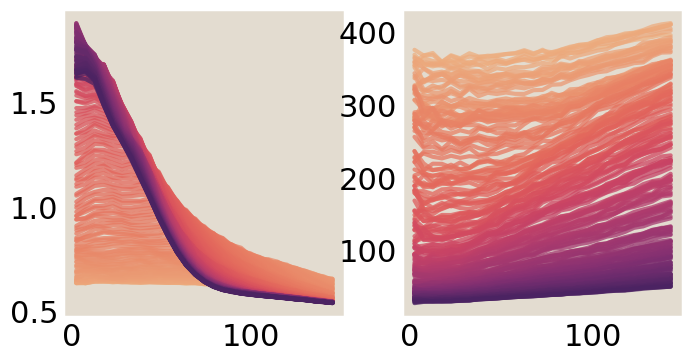

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
for time in range(rMotmids.shape[0]):
    ax[0].plot(rMotmids[time,:],
             rMotavgs[time,:], 
             alpha=0.75,
             color=global_time(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        

for time in range(rATPmids.shape[0]):
    ax[1].plot(rATPmids[time,:],
                           rATPavgs[time,:], alpha=0.75, 
                           color=global_time(timesATP[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        



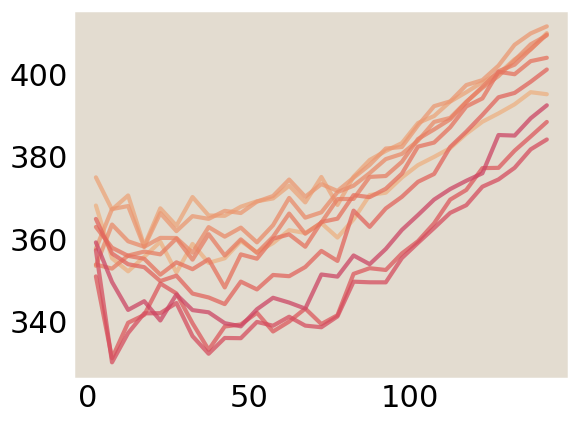

In [272]:
for time in range(10):
    plt.plot(rATPmids[time,:],
                           rATPavgs[time,:], alpha=0.75, 
                           color=global_timeCmap_ATP(timesATP[time*10]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        


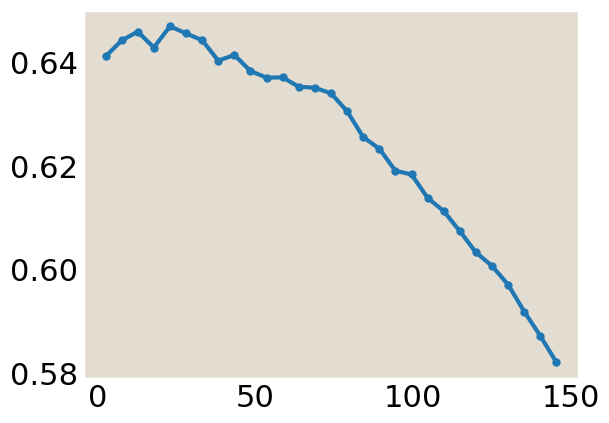

In [115]:
plt.plot(rMotmids[0,:], rMotavgs[0,:], marker='o', ms=5)

In [176]:
def sigmoid(arr, a, b, c, d):
    return a/(1+np.exp((arr - b)/c)) + d
def fitSigmoid(x, y, p0):
    param,_ = curve_fit(sigmoid, x, y, p0)
    return param

def quadratic(arr, a, b, c):
    return a*arr**2 + b*arr + c
def fitQuadratic(x, y, p0):
    param,_ = curve_fit(quadratic, x, y, p0)
    return param

def linear(arr, a, b):
    return a*arr + b
def fitLinear(x, y, p0):
    param,_ = curve_fit(linear, x, y, p0)
    return param
    
def exponential(arr, a, b, c):
    return a*np.exp(-arr/b)+c
def fitExponential(x, y, p0):
    param,_ = curve_fit(exponential, x, y, p0)
    return param

In [129]:
sigParams=[]
for t in np.arange(24, rMotmids.shape[0]):
    sigParams.append(fitSigmoid(rMotmids[t], rMotavgs[t], [rMotavgs[t].max()-rMotavgs[t].min(), 150-0.5*t, 1, rMotavgs[t].min()]))
sigParams=np.array(sigParams)

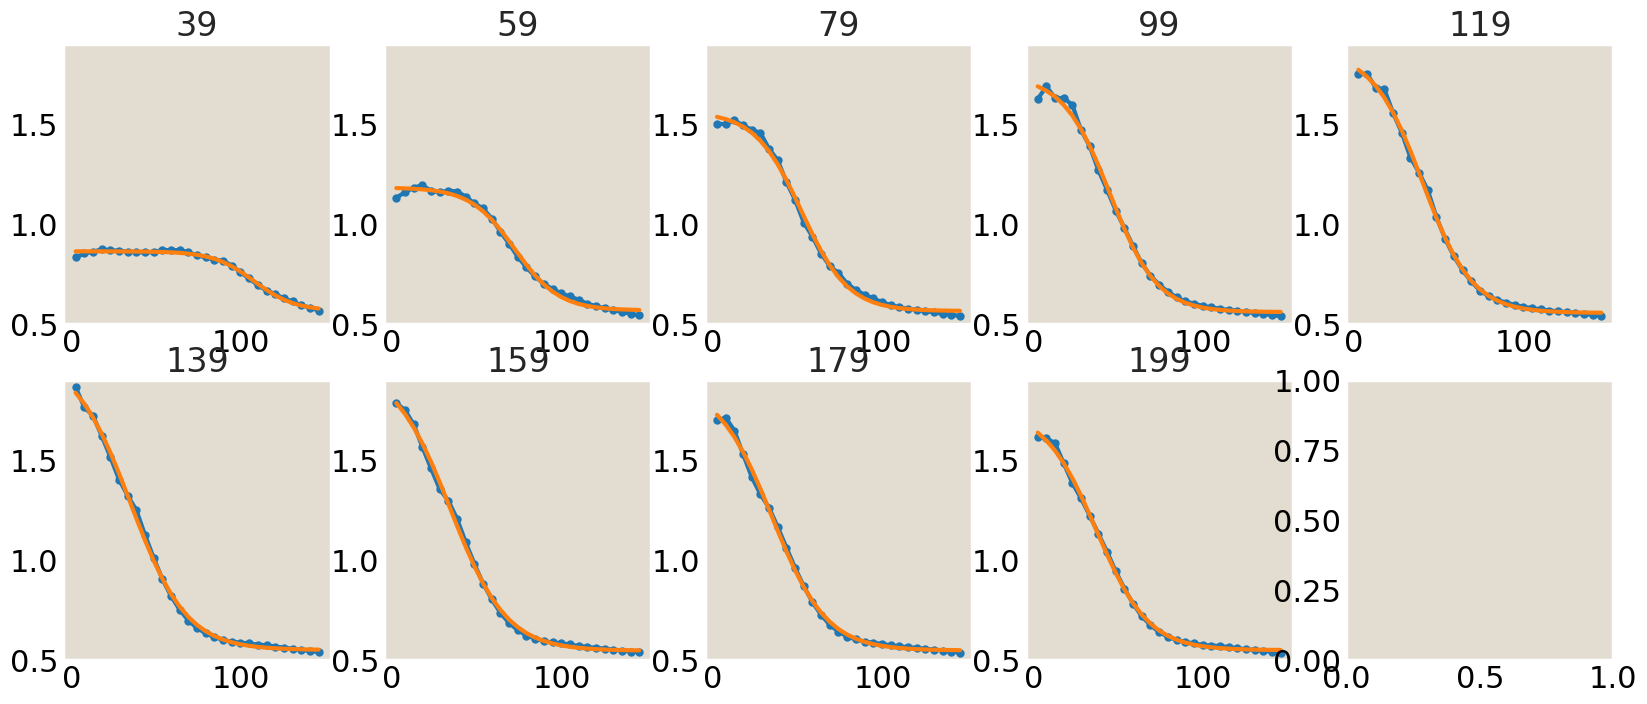

In [112]:
fig, ax = plt.subplots(2, 5, figsize = (20, 8))
for i,t in enumerate([39, 59, 79, 99, 119, 139, 159, 179, 199]):
    ax[int(i/5)][i%5].plot(rMotmids[t,:], rMotavgs[t,:], marker='o', ms=5)
    ax[int(i/5)][i%5].plot(rMotmids[t,:], sigmoid(rMotmids[t,:],*sigParams[t-39]))
    ax[int(i/5)][i%5].set_ylim(0.5, 1.9)
    ax[int(i/5)][i%5].set_title(t)

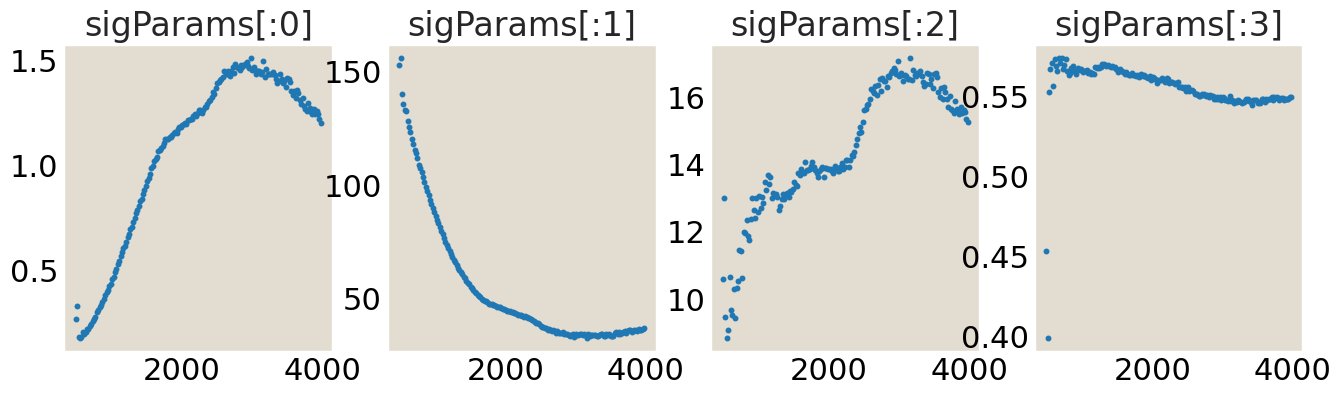

In [203]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
for i in range(4):
    ax[i].scatter(timesMot[24:], sigParams[:,i], s=5)
    ax[i].set_title(f'sigParams[:{i}]')

In [229]:
mlocparams = fitExponential(timesMot[24:], sigParams[:,1], [252, 30*20, 30])
mlocparams

array([252.07625459, 630.39127425,  33.27341868])

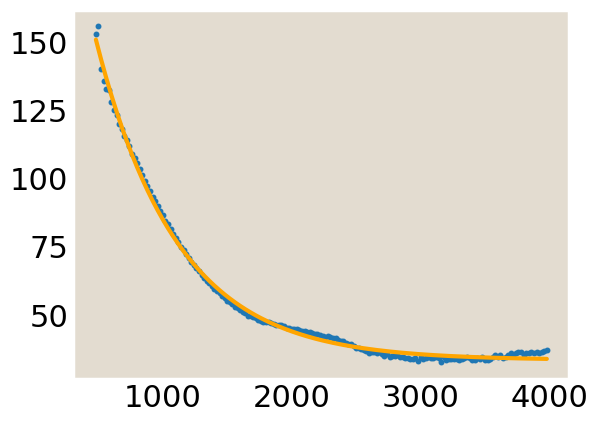

In [212]:
plt.scatter(timesMot[24:], sigParams[:,1], s=5)
plt.plot(timesMot[24:], exponential(timesMot[24:], *mlocparams), c='orange')

In [230]:
mheightparams = fitQuadratic(timesMot[24:], sigParams[:,0], [-8e-5*400, 0.02*20, 150])
mheightparams

array([-2.16380523e-07,  1.31687093e-03, -5.71789026e-01])

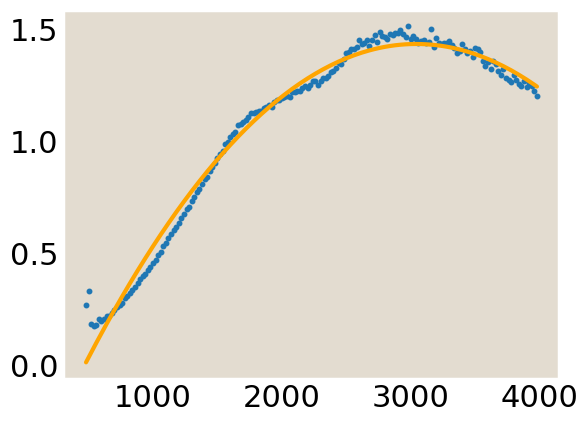

In [214]:
plt.scatter(timesMot[24:], sigParams[:,0], s=5)
plt.plot(timesMot[24:], quadratic(timesMot[24:], *mheightparams), c='orange')

In [231]:
mtauparams = fitQuadratic(timesMot[24:], sigParams[:,2], [-2e-4*400, 0.09*20, 150])
mtauparams

array([-5.96355096e-07,  4.34736037e-03,  8.32333649e+00])

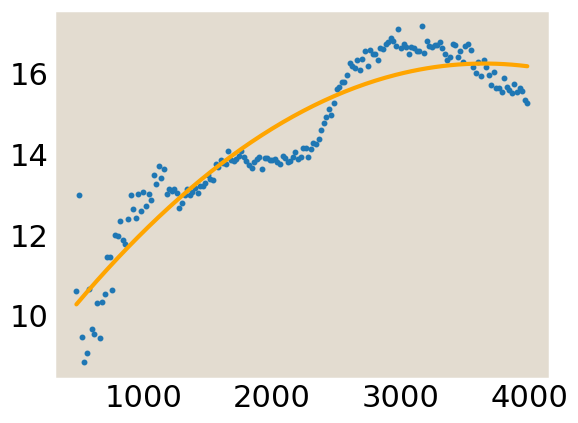

In [216]:
plt.scatter(timesMot[24:], sigParams[:,2], s=5)
plt.plot(timesMot[24:], quadratic(timesMot[24:], *mtauparams), c='orange')

In [232]:
minfparams = fitLinear(timesMot[24:], sigParams[:,3], [-0.3/10, 0.58])
minfparams

array([-5.00229280e-06,  5.67550561e-01])

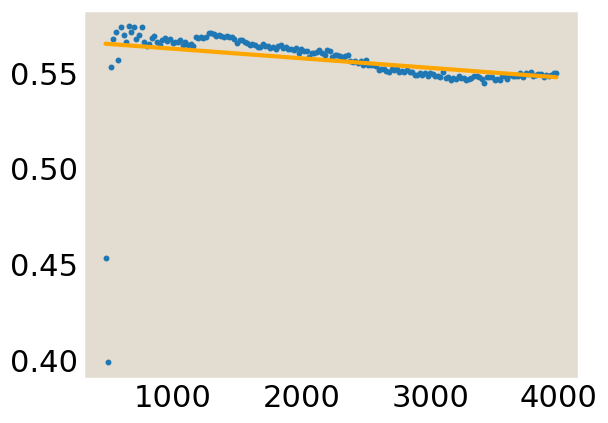

In [218]:
plt.scatter(timesMot[24:], sigParams[:,3], s=5)
plt.plot(timesMot[24:], linear(timesMot[24:], *minfparams), c='orange')

In [225]:
fitpeakval = quadratic(timesMot[:], *mheightparams)
fitpeakloc = exponential(timesMot[:], *mlocparams)
fitdecayconst = quadratic(timesMot[:], *mtauparams)
fitinfval = linear(timesMot[:], *minfparams)

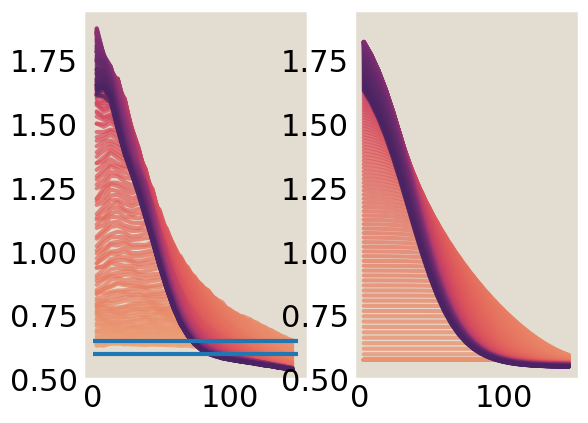

In [228]:
fig, ax = plt.subplots(1,2)
for time in range(rMotmids.shape[0]):
    ax[0].plot(rMotmids[time,:],
             rMotavgs[time,:], 
             alpha=0.75,
             color=global_timeCmap_Mot(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        
 
    if time>=24:
        ax[1].plot(rMotmids[time,:],
                 sigmoid(rMotmids[time,:], fitpeakval[time], fitpeakloc[time], fitdecayconst[time], fitinfval[time]), 
                 alpha=0.75,
                 color=global_timeCmap_Mot(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        
    else:
        ax[1].plot(rMotmids[time,:],
                 sigmoid(rMotmids[24,:], fitpeakval[24], fitpeakloc[24], fitdecayconst[24], fitinfval[24]), 
                 alpha=0.75,
                 color=global_timeCmap_Mot(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        


ax[0].set_ylim(0.5, 1.95)
ax[1].set_ylim(0.5, 1.95)
ax[0].hlines([0.6, 0.65], 0, 150)

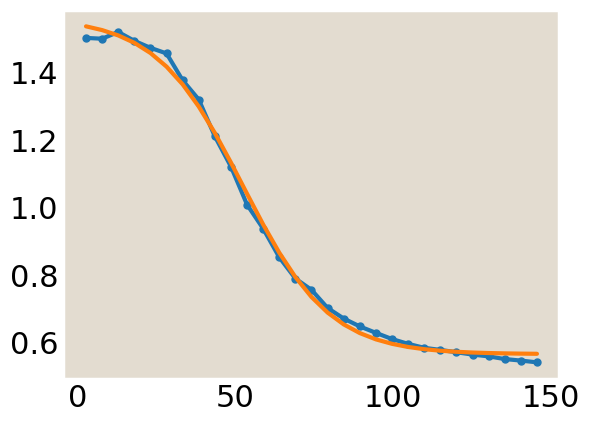

In [92]:
plt.plot(rMotmids[79,:], rMotavgs[79,:], marker='o', ms=5)
plt.plot(rMotmids[79,:], sigmoid(rMotmids[79,:],0.99635843, 52.33103712, 13.69094356,  0.56554719))

In [27]:
range(rMotmids.shape[0])

range(0, 200)

In [55]:
def normprof(mot_prof, radarr):
    """ 
    For a profile finds the peak and normalizes the relevant side
    parameters:
        mot_prof: array of concentration values for different radii 
        R_c: radius of the aster core - all radii lower than this will be mapped to this value as we only care from edge of core to tips or arms
    returns:
        norm_mot_prof[peak:]: the normalized profile to the right of the greatest value
        peak: location of the greatest value
    """
    mmax = np.max(mot_prof)
    peakidx = np.where(mot_prof==mmax)[0][0]
    peakloc = radarr[peakidx]
    mmin = np.min(mot_prof)
    norm_mot_prof = (mot_prof - mmin)/(mmax - mmin)
    return norm_mot_prof[peakidx:], peakidx, mmax, peakloc

In [62]:
# Create arrays to save the location and value of the peak at each time
peaksloc=[]
peaksval=[]

#find the peaks and save
for t, prof in enumerate(rMotavgs):
    
    _, _, peakval, peakloc = normprof(prof, rMotmids[0])
    peaksloc.append(peakloc)
    peaksval.append(peakval)
peaksloc=np.array(peaksloc)
peaksval=np.array(peaksval)


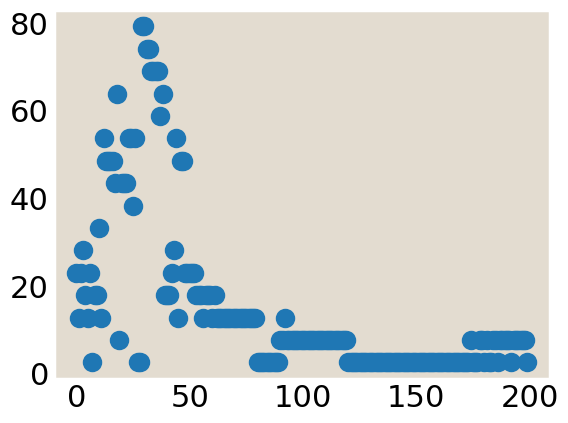

In [66]:
plt.scatter(range(len(peaksloc)), peaksloc)

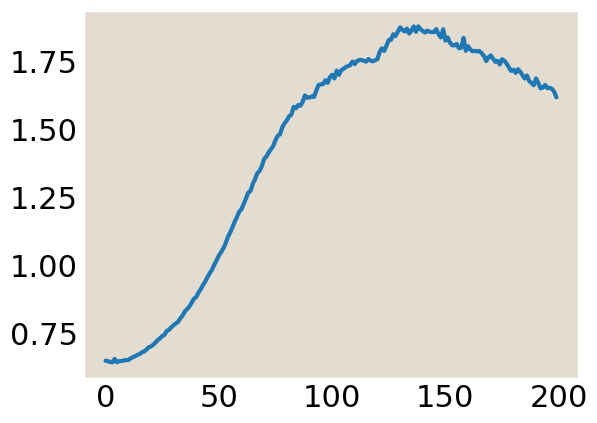

In [65]:
plt.plot(peaksval)

# comsol fig

In [56]:
molperm3_to_uM = 1e3
mtoum = 1e6

comsol_file_path = '../../data/COMSOL/20250315_ATP_Depletion_3D_eqn-input-sigmoid/'
comsol_file_name = 'xzproj_D6_timedepmot_ATPnotProjected'
comsol_file_type = '.txt'
comment = '%'
comsol_ATP_prof_df = pd.read_csv(comsol_file_path + comsol_file_name + comsol_file_type, comment=comment, names=["position (µm)", "ATP (µM)"])
comsol_mot_prof_df = pd.read_csv(comsol_file_path + 'xzproj_D6_timedepmot_motornotProjected' + comsol_file_type, comment=comment, names=["position (µm)", "Mot (µM)"])

#convert concentrations to µM
comsol_ATP_prof_df['ATP (µM)'] = comsol_ATP_prof_df['ATP (µM)']*molperm3_to_uM
comsol_mot_prof_df['Mot (µM)'] = comsol_mot_prof_df['Mot (µM)']*molperm3_to_uM

#convert positions to µm
comsol_ATP_prof_df['position (µm)'] = comsol_ATP_prof_df['position (µm)']*mtoum
comsol_mot_prof_df['position (µm)'] = comsol_mot_prof_df['position (µm)']*mtoum

t_start = 0 #initial time
t_end = 200*20 # final time
spacing = 20 # seconds between each measurement
interval = 1 #plotting interval

numb_times = int((t_end-t_start)/spacing)+1

comsol_times = np.linspace(t_start, t_start+spacing*(numb_times-1), numb_times) #given in s
tot_points = len(comsol_ATP_prof_df['position (µm)'])
numb_points = int(tot_points/numb_times)

comsol_time_ls = []
for t in comsol_times:
    for i in range(numb_points):
        comsol_time_ls.append(t)
        
comsol_ATP_prof_df['time (s)']= comsol_time_ls
comsol_mot_prof_df['time (s)']= comsol_time_ls

# depth = 60e-6 #m
# comsol_ATP_prof_df['ATP Conc'] = comsol_ATP_prof_df['ATP (mol/m^3)']/depth * molperm3_to_uM

In [45]:
comsol_mot_prof_df['position (µm)']

0        0.000000
1        0.000002
2        0.000005
3        0.000006
4        0.000007
           ...   
35773    0.000244
35774    0.000248
35775    0.000249
35776    0.000249
35777    0.000250
Name: position (µm), Length: 35778, dtype: float64

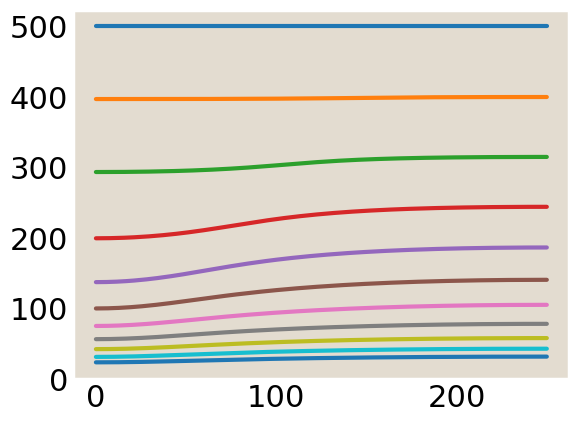

In [54]:
for t, time in enumerate(np.unique(comsol_time_ls)):
    if t%20==0:
        plt.plot(comsol_ATP_prof_df[comsol_ATP_prof_df['time (s)']==time]['position (µm)'],
                comsol_ATP_prof_df[comsol_ATP_prof_df['time (s)']==time]['ATP (µM)'])

/tmp/ipykernel_72878/3199962597.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: '../../analyzed_data/COMSOL/20250315_ATP_Depletion_3D_eqn-input-sigmoid/20250316_ExpAndComsol_D6_timedepsigmoid_notProjected.pdf'

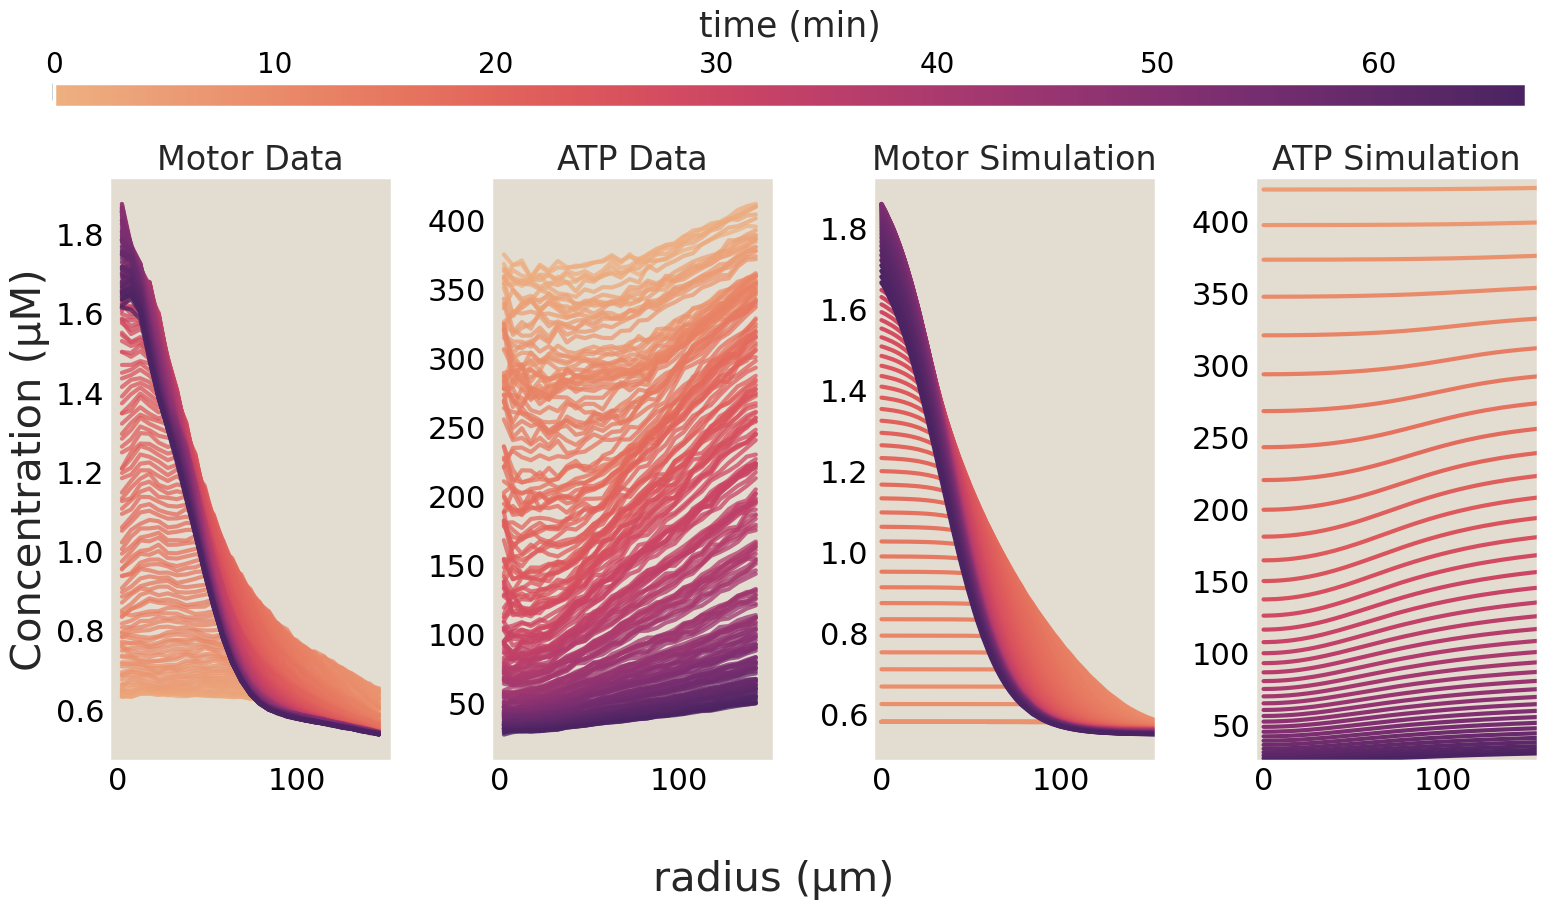

In [76]:
global_time_wcomsol=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=min([timesMot.min(), timesATP.min(), min(comsol_time_ls)]), vmax=max([timesMot.max(), timesATP.max(), max(comsol_time_ls)]))(time))

fig, ax = plt.subplots(1, 4, figsize=(16,8))
for time in range(rMotmids.shape[0]):
    ax[0].plot(rMotmids[time,:],
             rMotavgs[time,:], 
             alpha=0.75,
             color=global_time_wcomsol(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        

for time in range(rATPmids.shape[0]):
    ax[1].plot(rATPmids[time,:],
                           rATPavgs[time,:], alpha=0.75, 
                           color=global_time_wcomsol(timesATP[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        

for t, time in enumerate(np.unique(comsol_time_ls)):
    if t%2==0:
        ax[2].plot(comsol_mot_prof_df[comsol_mot_prof_df['time (s)']==time]['position (µm)'],
                   comsol_mot_prof_df[comsol_mot_prof_df['time (s)']==time]['Mot (µM)'],
                   color=global_time_wcomsol(time))

for t, time in enumerate(np.unique(comsol_time_ls)):
    if t%5 ==0:
        ax[3].plot(comsol_ATP_prof_df[comsol_ATP_prof_df['time (s)']==time]['position (µm)'],
                   comsol_ATP_prof_df[comsol_ATP_prof_df['time (s)']==time]['ATP (µM)'],
                   color=global_time_wcomsol(time))

for i in range(4):
    ax[i].set_xlim(ax[0].set_xlim())

ax[3].set_ylim(25, 430)
fig.supxlabel('radius (µm)', fontsize=30)
ax[0].set_ylabel('Concentration (µM)', fontsize=30)

ax[0].set_title('Motor Data')
ax[1].set_title('ATP Data')
ax[2].set_title('Motor Simulation')
ax[3].set_title('ATP Simulation')
######
# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # [left, bottom, width, height]

# Create the colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=min(comsol_time_ls)/60, 
                                                                 vmax=max(comsol_time_ls)/60)),
                    cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (min)', fontsize=25, labelpad=10)




fig.tight_layout()

plt.savefig('../../analyzed_data/COMSOL/20250315_ATP_Depletion_3D_eqn-input-sigmoid/20250316_ExpAndComsol_D6_timedepsigmoid_notProjected.pdf', 
            bbox_inches='tight')

In [ ]:
atpTimes=[l[0] for l in allTimes_forFiles]
motTimes=[l[1] for l in allTimes_forFiles]
minMottime, maxMottime=min(np.concatenate(motTimes)), max(np.concatenate(motTimes))
minATPtime, maxATPtime=min(np.concatenate(atpTimes)), max(np.concatenate(atpTimes))
print(minMottime, maxMottime)
print(minATPtime, maxATPtime)

# define helper function that takes as input an atp time and gives color
global_timeCmap_ATP=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=minATPtime, vmax=maxATPtime)(time))
global_timeCmap_Mot=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=minMottime, vmax=maxMottime)(time))


In [ ]:
mod_num = 8

fig, ax = plt.subplots(1, 4, figsize=(18, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=timesMot.min(), vmax=0.6*timesMot.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(timesMot)

# for i, frame in enumerate(plot_frames):
#     if i%mod_num==0:
#         ax[0].plot(output_Cherry[i]['r_unif_ls_um'],
#                  output_Cherry[i]['avg_ls_cu_smoo'],
#                  lw=3,
#                  color = colormap(normalize(plot_times[i])),
#                  label=str(round(plot_times[i], 2)))

#         ax[1].plot(output_ratios[i]['r_unif_ls_um'],
#                  output_ratios[i]['avg_ls_cu_smoo'],
#                  lw=3,
#                  color = colormap(normalize(plot_times[i])),
#                  label=str(round(plot_times[i], 2)))
        
# m0 = 5 #uM
# minf = 1 #uM
# Ra = 40 # um
# Rc = 15 #um
# Tf = 10 #min
# lamdecay = 10 #um
# pos_data = np.arange(50)
# dr = 1

# for t, time in enumerate(tqdm(comsol_times[:15])):
#     conc_data = motfunc(pos_data, dr, time, Tf, m0, minf, Ra, Rc, lamdecay)
#     #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
#     ax[2].plot(pos_data,
#              conc_data,
#              lw=3,
#              color = colormap(normalize(time)),
#              label=str(round(time, 1)))

mod_num=1   

for t, time in enumerate((comsol_times[:8])):
    if t%mod_num==0:
        pos_data = comsol_mot_prof_df.loc[comsol_mot_prof_df['time (min)'] == time, 'position'].values[:]*1000000
        conc_data = comsol_mot_prof_df[comsol_mot_prof_df['time (min)'] == time]['Mot (µM)'].values[:]
        #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
        ax[2].plot(pos_data,
                 conc_data*1000,
                 lw=3,
                 color = colormap(normalize(time/60)),
                 label=str(round(time/60, 1)))
        ax[2].set_xlim(-4, 62)
        
# for t, time in enumerate(tqdm(comsol_times[:10])):
#     if t%mod_num==0:
#         pos_data = comsol_motout_prof_df.loc[comsol_motout_prof_df['time (min)'] == time, 'position'][R_c_idx:].values[:]*1000000
#         conc_data = comsol_motout_prof_df[comsol_motout_prof_df['time (min)'] == time]['Mot (µM)'][R_c_idx:].values[:]
#         #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
#         ax[2].plot(pos_data,
#                  conc_data*1000,
#                  lw=3,
#                  color = colormap(normalize(time/60)),
#                  label=str(round(time/60, 1)))
#         ax[2].set_xlim(-4, 62)

# mod_num=2  

# for t, time in enumerate(tqdm(comsol_times[:40])):
#     if t%mod_num==0:
#         pos_data = comsol_ATP_prof_df.loc[comsol_ATP_prof_df['time (min)'] == time, 'position'].values[:]*1000000
#         conc_data = comsol_ATP_prof_df[comsol_ATP_prof_df['time (min)'] == time]['ATP (µM)'].values[:]
#         #ax.plot(pos_data, conc_data, label= str(round(t,1)), linewidth = 4)
#         ax[3].plot(pos_data,
#                  conc_data*1000,
#                  lw=3,
#                  color = colormap(normalize(time/60)),
#                  label=str(round(time/60, 1)))
#         ax[3].set_xlim(-4, 62)


# #ax[0].set_box_aspect(1.5)
# #ax[1].set_box_aspect(1.5)

# fig.supxlabel('Distance from aster center (µm)', fontsize=30)
# ax[0].set_ylabel('Concentration (µM)', fontsize=30)
# # ax[0].set_ylabel('Motor Concentration (µM)')
# # ax[1].set_ylabel('ATP Concentration (µM)')
# # ax[0].set_xlabel('Distance from aster center (µm)')
# # ax[1].set_xlabel('Distance from aster center (µm)')

# ax[0].set_facecolor(color_background)
# ax[1].set_facecolor(color_background)
# ax[2].set_facecolor(color_background)
# ax[3].set_facecolor(color_background)

# ax[0].tick_params('both', labelsize=20)
# ax[1].tick_params('both', labelsize=20)
# ax[2].tick_params('both', labelsize=20)
# ax[3].tick_params('both', labelsize=20)

# ax[1].set_ylim(-20, 550)
# ax[3].set_ylim(-20, 550)

# ax[0].set_ylim(0.8, 5.7)
# ax[2].set_ylim(0.8, 5.7)

# fig.subplots_adjust(right=0.8)
# color_bar_ax = fig.add_axes([0.81, 0.13, 0.03, 0.75])
# cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
# cbar.ax.tick_params(labelsize=25)
# cbar.set_label(label="Times (min)", size=30, weight='bold')
# cbar.ax.invert_yaxis()

KeyboardInterrupt: 

# power shit

In [254]:
def float_avg(array, window):
    """ 
    Smooths noisy data by replacing individual values with the average of neighboring values
    
    Params:
    array: array of data to smooth
    window: half the interval (how many points to each side) you want to average over. - note this function does something strange 
    at the end where the last point takes the interval before and averages forgetting the interval after.So if your window is 1, 
    you average over 3 points, i-1, i, i+1. For the last point in the array, you only average two i-1, and i. I don't understand 
    why it isn't throwing an error but I am going with it. Note, I am keeping the first window value of points equal to their original 
    value without averageing. So in this case i=0 stays its original value and we start averaging when i=1
    
    Returns:
    Smoothed array witht he same length as the inputted array
    
    """
    smoo_array = []
    for i in range(len(array)):
        if i<window:
            smoo_array.append(array[i])
        else:
            smoo_array.append(np.average(array[i-window:i+window+1]))
    smoo_array = np.array(smoo_array)
    return smoo_array

In [266]:
h5dic.keys()


dict_keys(['ATP_centCrop', 'Mot_shell_vol_L', 'mot', 'all_rMotbins', 'ATPShells', 'all_rATPavgs', 'timesMot', 'imshape', 'MotShells', 'ATP_shell_vol_L', 'powerShells', 'timesPower', 'all_rMotavgs', 'ATP', 'mask_coords', 'mot_centCrop', 'timesATP', 'all_rATPbins'])

(0.0, 600000000.0)

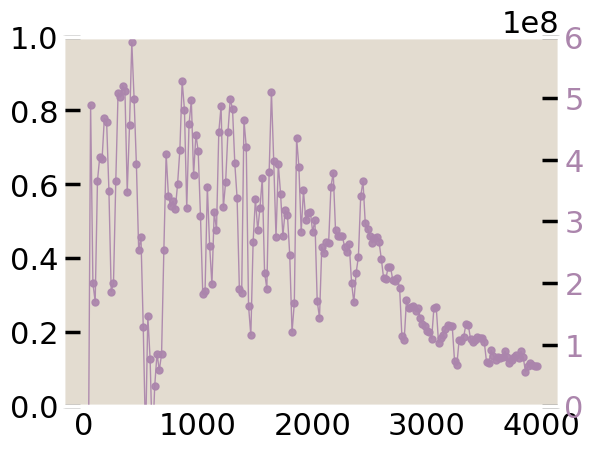

In [285]:
fig, ax = plt.subplots()
#asterRadii=h5dic['radii']*umperpixel
#times=np.arange(len(asterRadii))*20; #20 seconds interval

# also import power
totalPowers=np.sum(h5dic['powerShells'], axis=1)
smoothwindow=4
totalPowers=float_avg(totalPowers, smoothwindow)
times_power=h5dic['timesPower']

# for time in range(len(times)):
#     axs[rowCounter, colCounter].plot(times[time],
#                            asterRadii[time], 'o', alpha=0.7+((time%20)==0)*0.2, 
#                            color=sns.color_palette("flare", as_cmap=True)(time/len(times)), lw=2) 
#     ## also plot apparent total power
#     twin=axs[rowCounter, colCounter].twinx()
#     twin.plot(times[time],
#                            totalPowers[time], 'o-', alpha=0.7+((time%20)==0)*0.2, 
#                            color=sns.color_palette("crest", as_cmap=True)(time/len(times)), lw=2)

# plt.plot(times, asterRadii, '-', color=color_palette()['green'], label='radius', lw=6, alpha=0.93)
# yticklabels=ax.get_yticklabels()
# for label in yticklabels:
#     label.set_color(color_palette()['green']) 
# plt.tick_params(axis='y', which='both', length=0)  # Set tick line length to 0
twin=ax.twinx()
twin.plot(times_power, totalPowers, 'o-', ms=5, color=color_palette()['purple'], label='power', lw=1, alpha=0.93)
yticklabels=twin.get_yticklabels()
for label in yticklabels:
    label.set_color(color_palette()['purple']) 
            # Define the formatter functio
twin.set_ylim(0, 6e8)

In [ ]:
# run this indeed.
### aster raddii flexible axes limits
uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(34, 32))#, sharex=True, sharey=True)
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(uniqueConcs)):
    c = uniqueConcs[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(allProps_verb[:, 1] == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(r'$' + str(uniqueConcs[ii]) + r'\ \mu$M NCD')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        axs[rowCounter, colCounter].set_title(allProps_verb[idxsForThisC[j], 0], fontsize=14, color='grey')
        # Plot data
        #axs[rowCounter, colCounter].plot(1, 1, 'ro')
        ## get this gname's analyzed data files & parse
        #axs[thisSubplIdx].plot(1,1, 'ro')
        h5spath=gnameList[idxsForThisC[j]].split('data')[0]+'analyzed_data'+gnameList[idxsForThisC[j]].split('data')[1]+'/'
        h5dic = read_h5py(h5spath)
    
        # this is (numTimes, numRbinMidpoints)
        asterRadii=h5dic['radii']*umperpixel
        times=np.arange(len(asterRadii))*20; #20 seconds interval

        # also import power
        totalPowers=np.sum(h5dic['powerShells'], axis=1)
        smoothwindow=4
        totalPowers=float_avg(totalPowers, smoothwindow)
        times_power=h5dic['timesPower']
        
        # for time in range(len(times)):
        #     axs[rowCounter, colCounter].plot(times[time],
        #                            asterRadii[time], 'o', alpha=0.7+((time%20)==0)*0.2, 
        #                            color=sns.color_palette("flare", as_cmap=True)(time/len(times)), lw=2) 
        #     ## also plot apparent total power
        #     twin=axs[rowCounter, colCounter].twinx()
        #     twin.plot(times[time],
        #                            totalPowers[time], 'o-', alpha=0.7+((time%20)==0)*0.2, 
        #                            color=sns.color_palette("crest", as_cmap=True)(time/len(times)), lw=2)
        
        axs[rowCounter, colCounter].plot(times, asterRadii, '-', color=color_palette()['green'], label='radius', lw=6, alpha=0.93)
        yticklabels=axs[rowCounter, colCounter].get_yticklabels()
        for label in yticklabels:
            label.set_color(color_palette()['green']) 
        axs[rowCounter, colCounter].tick_params(axis='y', which='both', length=0)  # Set tick line length to 0

        twin=axs[rowCounter, colCounter].twinx()
        twin.plot(times_power, totalPowers, '-', color=color_palette()['purple'], label='power', lw=6, alpha=0.93)
        yticklabels=twin.get_yticklabels()
        for label in yticklabels:
            label.set_color(color_palette()['purple']) 
                    # Define the formatter function
        def scientific_notation_formatter(value, tick_number):
            return r"${:.1g} \times 10^9$".format(value / 1e9)
        
        # Apply the formatter to the y-axis
        twin.yaxis.set_major_formatter(ticker.FuncFormatter(scientific_notation_formatter))

        # Remove y-axis tick lines while keeping the labels
        twin.tick_params(axis='y', which='both', length=0)  # Set tick line length to 0


        
        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1


# [r'$' + str(c) + r'\ \mu$M NCD' for c in uniqueConcs]
# hack for labeling
axs[5,0].set_ylabel(r'$' + str(uniqueConcs[4]) + r'\ \mu$M NCD');
axs[6,0].set_ylabel(r'$' + str(uniqueConcs[4]) + r'\ \mu$M NCD');

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

plt.suptitle('total power and aster radius')
# Add a common x-label
fig.text(0.5, -0.01, 'radial position $r$ / $\mu$m', ha='center', va='center')
# Add a common y-label
fig.text(-0.01, 0.5, 'aster radius / $\mu$m', ha='center', va='center', rotation=90, color=color_palette()['green'])
fig.text(1+0.01, 0.5, 'power (ATP/s)', ha='center', va='center', rotation=90, color=color_palette()['purple'])


# axs[0,0].set_ylim([-0.01, 500])
# axs[0,0].set_xlim([-0.01, 27])

# Adjust layout and display the plot
plt.tight_layout()

#plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_power_asterRadii_smooth4power.pdf', bbox_inches='tight')

In [253]:
h5dic['powerShells']

array([[-1.13436542e+06, -5.88297037e+06, -1.52645025e+07, ...,
        -9.59264332e+07, -9.47181828e+07, -1.40130036e+08],
       [ 2.87021075e+06, -5.91840705e+04,  2.13143419e+06, ...,
        -3.09971465e+07, -3.53717343e+07, -1.55993233e+07],
       [ 6.93254682e+05,  1.86421738e+06,  7.09209048e+06, ...,
         3.30725269e+07,  2.41388425e+07,  2.06964319e+07],
       ...,
       [-2.88102231e+05,  9.77345827e+04, -1.45527802e+05, ...,
         2.58063556e+06,  3.48167132e+06,  2.14092109e+06],
       [ 1.21169449e+05,  3.32987252e+05, -2.81894081e+05, ...,
        -5.44901027e+06, -6.41803680e+06, -8.01131568e+06],
       [ 3.58003133e+05,  2.43379655e+05,  2.09398437e+05, ...,
         9.41080341e+06,  7.26138101e+06,  8.64410011e+06]],
      shape=(198, 29))